In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd

%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

In [26]:
# Setup the figures
style='talk'
execfile('/Users/ttshimiz/Dropbox/Research/figure_setup.py')

In [3]:
# Upload the fits for the BAT AGN
bat_casey = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_v5.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_v2.csv', index_col=0)

# Get rid of the galaxies that are radio-loud and/or have bad fits
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12)

In [4]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)
hrs_casey_undetected = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected_hrs.csv', index_col=0)
hrs_all = pd.concat([hrs_casey, hrs_casey_undetected])
hrs_all.loc[hrs_casey_undetected.index, 'Flag'] = -1
hrs_all.loc[hrs_casey.index, 'Flag'] = 0
# Remove the BAT AGN in the HRS
hrs_all = hrs_all.drop([4,144,288,296])

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)
hrs_info = hrs_info.drop([4,144,288,296])

# HRS gas-rich galaxies
hrs_gas_rich = np.array([np.loadtxt(gh_dir+'hrs-data/hrs_gas_rich_numbers.txt')], dtype = int)[0]

hrs_all['Mstar'] = hrs_info['logMstart']

# Upload the IDs for our mass selected HRS sample
mass_select = pd.read_csv('mass_selected_hrs_ids.csv', index_col=0)
hrs_mass_select = pd.DataFrame(index=mass_select.index, columns=hrs_all.columns)

for n in mass_select.index:
    
    hrs_mass_select.loc[n] = hrs_all.loc[np.int(mass_select.loc[n, 'HRS ID'])]
    hrs_mass_select.loc[n, 'HRS ID'] = np.int(mass_select.loc[n, 'HRS ID'])

In [5]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv', index_col=0)

# Upload teh KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt', index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
kf_dwarfs = kf_info['Mstar'] < 8.5
kf_agn = (kf_info['Nuc. Type'] == 'AGN') | (kf_info['Nuc. Type'] == 'SF/AGN')
kf_casey['Mstar'] = kf_info['Mstar']

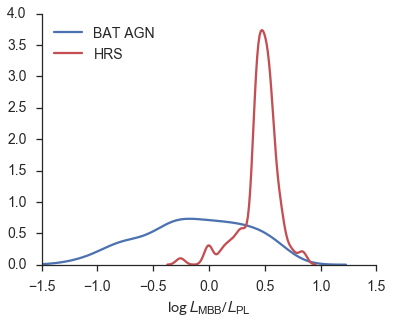

In [28]:
#fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
fig = plt.figure(figsize=(6, 4.5))
sn.kdeplot((bat_casey['lir_bb'] - bat_casey['lir_powlaw']).dropna(), label='BAT AGN')
sn.kdeplot((hrs_mass_select['lir_bb'] - hrs_mass_select['lir_powlaw'])[hrs_mass_select['Flag']==0].dropna(), label='HRS', color='r')
#sn.distplot((kf_casey.loc[~kf_dwarfs, 'lir_bb'] - kf_casey.loc[~kf_dwarfs, 'lir_powlaw']).dropna(), label='KINGFISH')
plt.xlabel('$\log\,L_{\mathdefault{MBB}}/L_{\mathdefault{PL}}$')
plt.legend(loc='upper left')
plt.xlim(-1.5, 1.5)
sn.despine()
plt.savefig('/Users/ttshimiz/Dropbox/Research/Thesis/Dissertation/presentation/lmbb-lpl-ratio-hrs-mass-select.pdf', bbox_inches='tight')

In [14]:
from astropy.stats import sigma_clipped_stats
mean_hrs_ratio, median_hrs_ratio, std_hrs_ratio = sigma_clipped_stats(np.array([(hrs_mass_select['lir_bb'] - hrs_mass_select['lir_powlaw'])[hrs_mass_select['Flag'] == 0].dropna()], dtype=np.float))
#mean_kf_ratio, median_kf_ratio, std_kf_ratio = sigma_clipped_stats((kf_casey.loc[~kf_dwarfs, 'lir_bb'] - kf_casey.loc[~kf_dwarfs, 'lir_powlaw']).dropna())
#mean_ratio, median_ratio, std_ratio = sigma_clipped_stats(np.hstack([(hrs_casey['lir_bb'] - hrs_casey['lir_powlaw']).dropna().values, (kf_casey.loc[~kf_dwarfs, 'lir_bb'] - kf_casey.loc[~kf_dwarfs, 'lir_powlaw']).dropna().values]))
print 'HRS: ',mean_hrs_ratio, median_hrs_ratio, std_hrs_ratio
#print 'KINGFISH: ', mean_kf_ratio, median_kf_ratio, std_kf_ratio
#print 'All: ', mean_ratio, median_ratio, std_ratio

 HRS:  0.480406472079 0.480739352 0.12935475994


We can calculate an AGN fraction for the HRS and KINGFISH galaxies assuming they have an AGN. This will give us a constraint on how well we can measure the AGN fraction.

In [18]:
hrs_mass_select['agnfrac'] = (10**hrs_mass_select['lir_powlaw'] - 1./3.*10**hrs_mass_select['lir_bb'])/10**(hrs_mass_select['lir_total'])
#kf_casey['agn_frac'] = (10**kf_casey['lir_powlaw'] - 1./3.*10**kf_casey['lir_bb'])/10**(kf_casey['lir_total'])

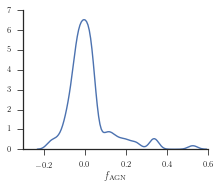

In [23]:
fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
#sn.distplot(np.hstack([hrs_casey['agn_frac'].dropna(), kf_casey[~kf_dwarfs]['agn_frac'].dropna()]))
sn.kdeplot(hrs_mass_select['agnfrac'][hrs_mass_select['Flag'] == 0].dropna())
plt.legend([])
plt.xlabel(r'$f_{\rm AGN}$')
sn.despine()
plt.savefig(figsave_dir+'fagn_nonAGN_hrs_mass_select.pdf', bbox_inches='tight')

In [22]:
#nonAGN_fagn = np.hstack([hrs_casey['agn_frac'].dropna(), kf_casey[~kf_dwarfs]['agn_frac'].dropna()])
nonAGN_fagn = hrs_mass_select['agn_frac'][hrs_mass_select['Flag']==0].dropna()
clipped = stats.sigmaclip(nonAGN_fagn, low=3, high=3)
mean_fagn = np.median(nonAGN_fagn)
std_fagn = np.std(nonAGN_fagn)

print 'AGN fraction of Non-AGN galaxies: ', mean_fagn, '+/-', std_fagn

AGN fraction of Non-AGN galaxies:  -0.00117738801981 +/- 0.106636495051
